In [1]:
def visualize_pcd_2d_rgb(
    pcd_path: str,
    voxel_size: float = None,
    angle_deg: float = 0.0,
    grid_size: float = None,
    brightness: float = 1.0,
    figsize=None,        # 예: (8, 6)
    dpi=None,            # 예: 150, 300
):
    import open3d as o3d
    import numpy as np
    import matplotlib.pyplot as plt

    # 1) PCD 로드
    pcd = o3d.io.read_point_cloud(pcd_path)
    if pcd.is_empty():
        print(f"[!] Empty point cloud: {pcd_path}")
        return

    # 2) (옵션) 다운샘플링
    if voxel_size is not None:
        pcd = pcd.voxel_down_sample(voxel_size)
        print(f"[+] Downsampled with voxel_size={voxel_size}")

    pts = np.asarray(pcd.points)  # (N, 3)
    if pts.shape[1] < 3:
        print("[!] Point cloud does not have 3D coordinates.")
        return

    # 좌표
    x = pts[:, 0]
    y = pts[:, 1]

    # 색상: RGB 사용
    if len(pcd.colors) > 0:
        colors = np.asarray(pcd.colors, dtype=float)  # (N, 3)
        cmax = colors.max()
        if cmax > 1.0:
            print(f"[+] Detected color max={cmax:.1f} (>1). Scale down by 255.")
            colors = colors / 255.0
        if brightness != 1.0:
            colors = np.clip(colors * brightness, 0.0, 1.0)
            print(f"[+] Applied brightness factor: {brightness}")
    else:
        colors = np.full((pts.shape[0], 3), 0.5, dtype=float)  # 회색

    # 3) XY 회전 (z축 기준)
    if angle_deg != 0.0:
        theta = np.deg2rad(angle_deg)
        c, s = np.cos(theta), np.sin(theta)
        R = np.array([[c, -s],
                      [s,  c]], dtype=float)
        xy = np.stack([x, y], axis=0)       # (2, N)
        xy_rot = R @ xy                     # (2, N)
        x, y = xy_rot[0], xy_rot[1]
        print(f"[+] Rotated XY by {angle_deg} degrees (CCW).")

    # 4) Figure & Axes: 캔버스 전체를 쓰는 축 만들기 (테두리/패딩 제거)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])  # [left, bottom, width, height] in 0~1

    if grid_size is None:
        # --- 그냥 점 뿌리기 ---
        ax.scatter(x, y, c=colors, s=1, marker='.')
    else:
        # --- 그리드로 래스터라이즈 ---
        x_min, x_max = x.min(), x.max()
        y_min, y_max = y.min(), y.max()

        nx = int(np.ceil((x_max - x_min) / grid_size))
        ny = int(np.ceil((y_max - y_min) / grid_size))

        if nx <= 0 or ny <= 0:
            print("[!] Invalid grid size / bounds.")
            return

        img_r = np.zeros((ny, nx), dtype=float)
        img_g = np.zeros((ny, nx), dtype=float)
        img_b = np.zeros((ny, nx), dtype=float)
        count = np.zeros((ny, nx), dtype=float)

        ix = ((x - x_min) / grid_size).astype(int)
        iy = ((y - y_min) / grid_size).astype(int)

        ix = np.clip(ix, 0, nx - 1)
        iy = np.clip(iy, 0, ny - 1)

        r = colors[:, 0]
        g = colors[:, 1]
        b = colors[:, 2]

        np.add.at(img_r, (iy, ix), r)
        np.add.at(img_g, (iy, ix), g)
        np.add.at(img_b, (iy, ix), b)
        np.add.at(count, (iy, ix), 1.0)

        mask = count > 0
        img_r[mask] /= count[mask]
        img_g[mask] /= count[mask]
        img_b[mask] /= count[mask]

        img = np.stack([img_r, img_g, img_b], axis=-1)
        img = np.flipud(img)

        extent = [x_min, x_max, y_min, y_max]
        ax.imshow(img, extent=extent, origin='lower')

    ax.set_aspect("equal", adjustable="box")
    ax.axis("off")
    plt.savefig("pcd_2d.png", bbox_inches='tight', pad_inches=0)
    plt.show()
    


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[+] Downsampled with voxel_size=0.2


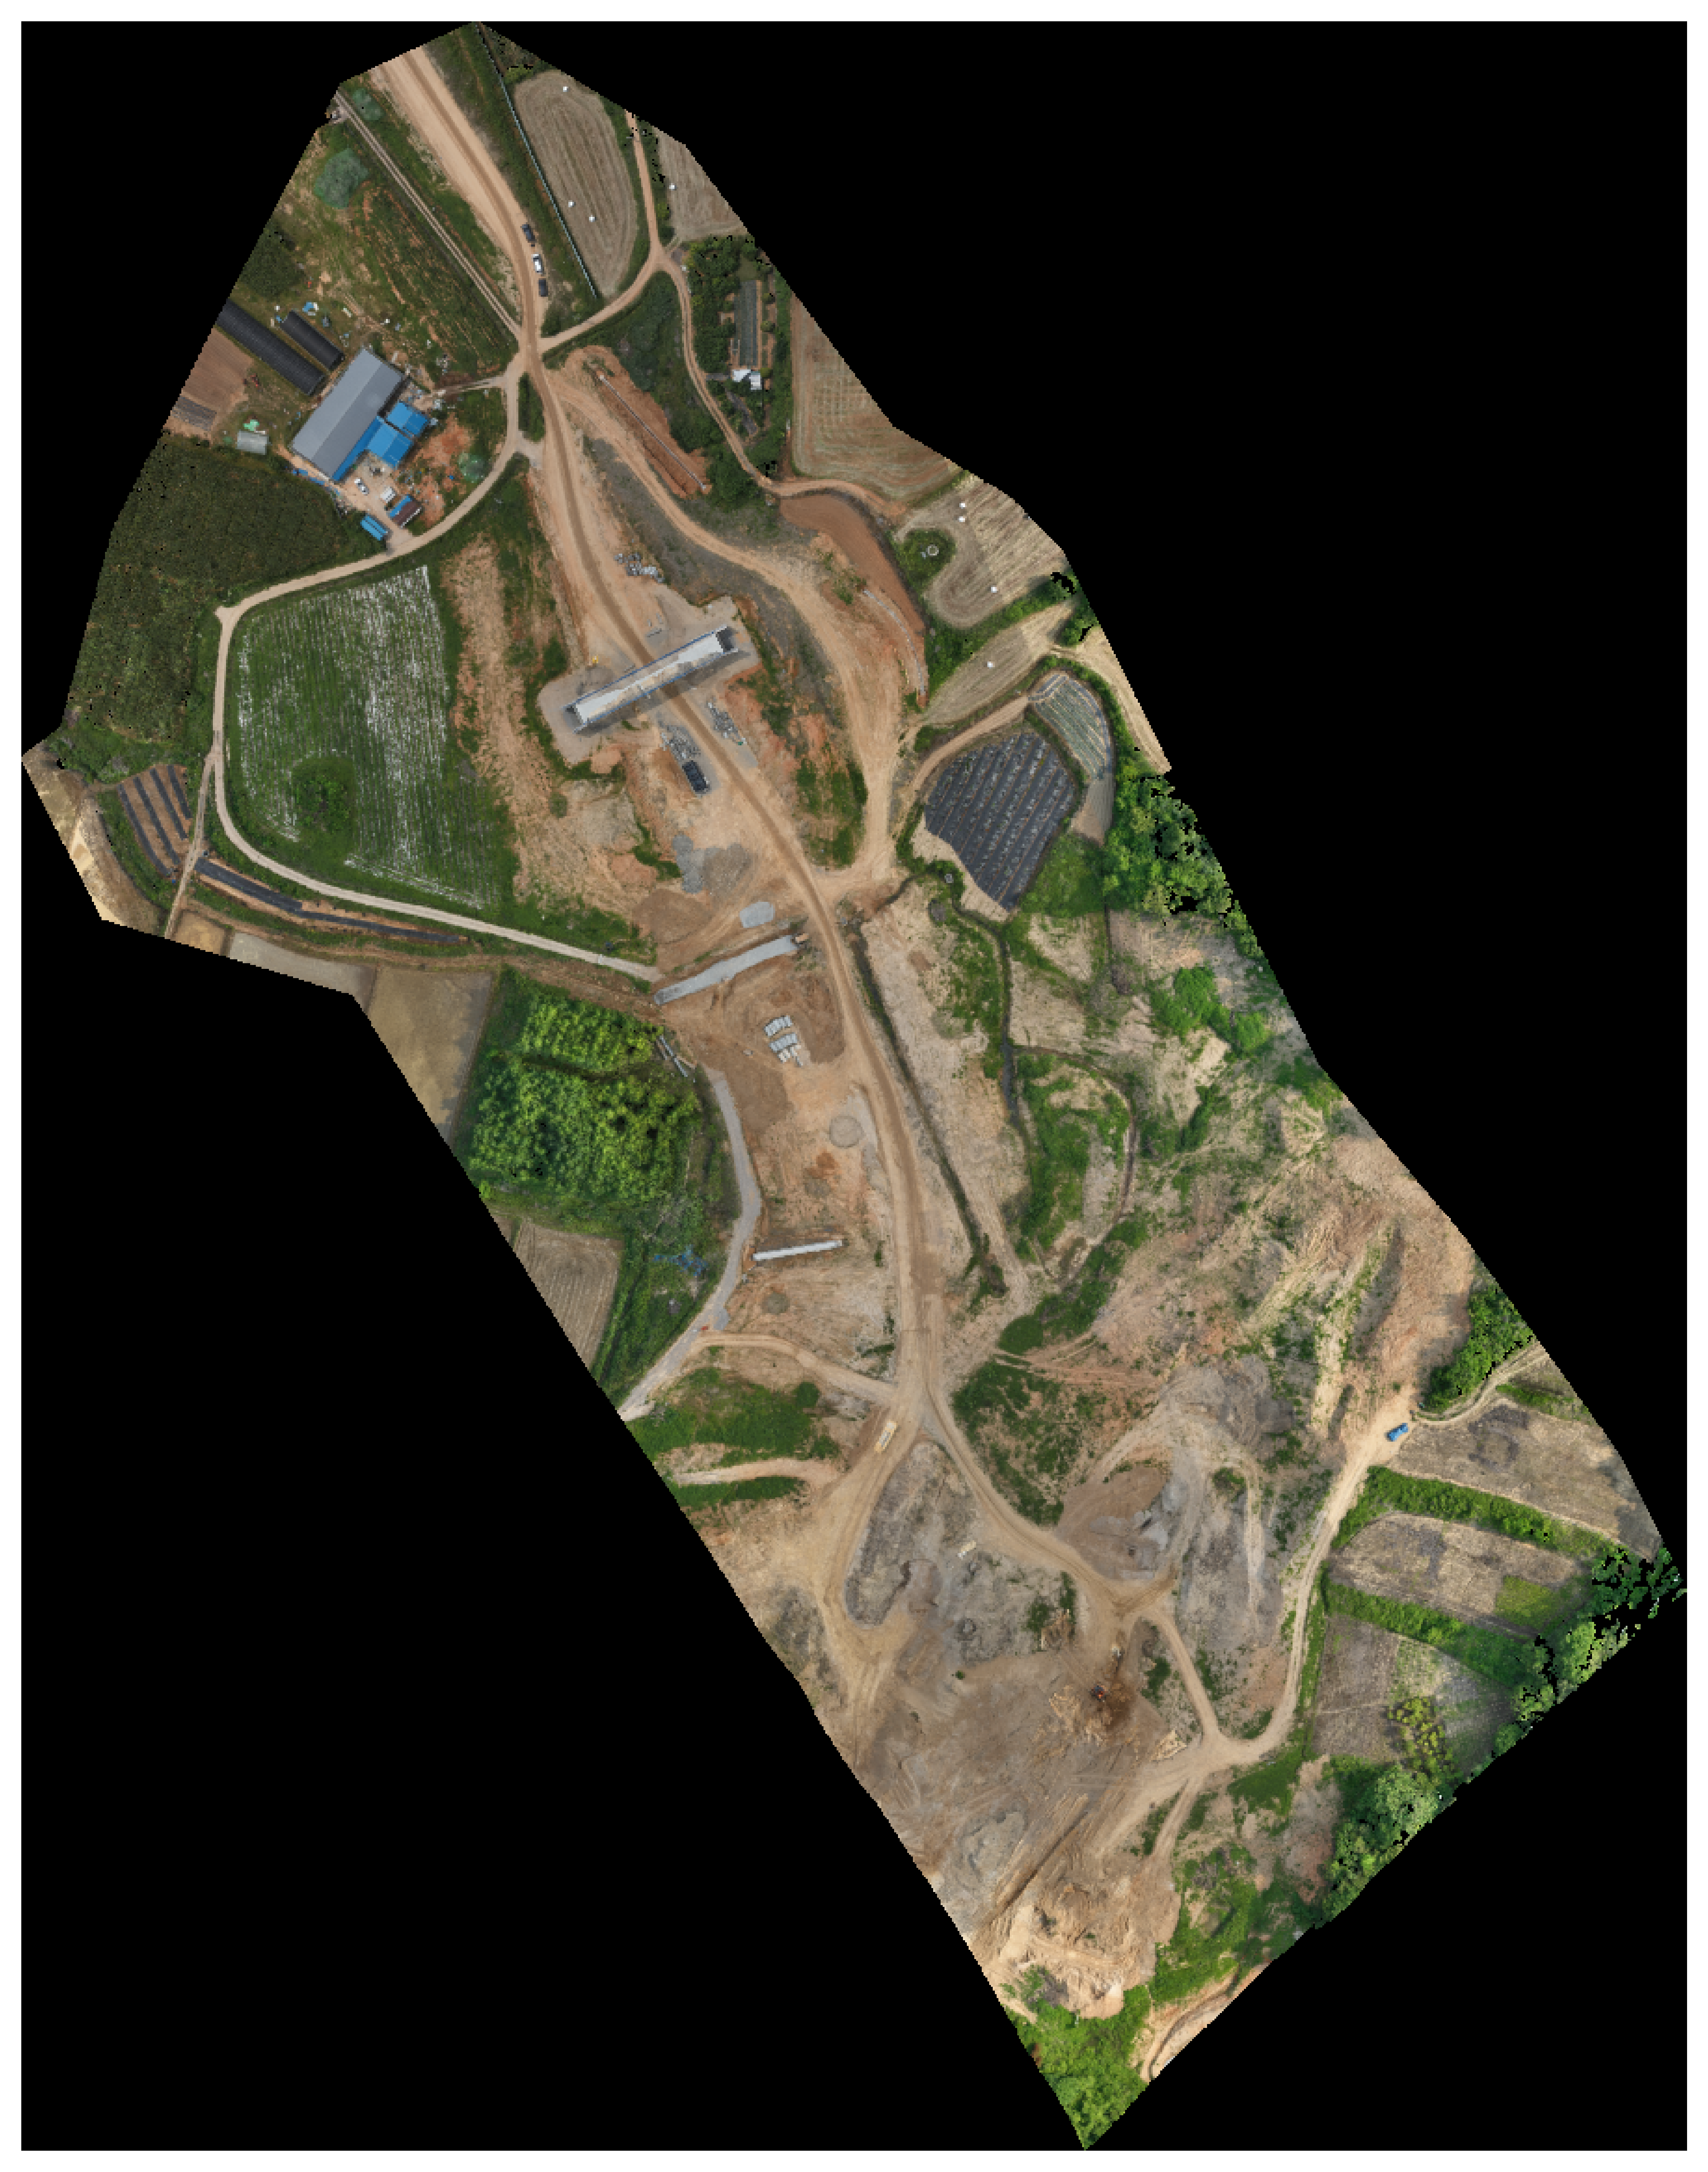

In [2]:
visualize_pcd_2d_rgb(
    "/workspace/PCD_FILES/gangjin.pcd",
    voxel_size=0.2,
    angle_deg=0.0,
    grid_size=0.5,
    brightness=1.0,
    figsize=(10, 10),  # 정사각형 10인치
    dpi=600,           # 해상도
)
